# Análisis Longitudinal Integral

Este cuaderno consolida el análisis histórico de la universidad, abarcando cuatro dimensiones clave:
1.  **Deserción:** Tasa de bajas en relación con la matrícula.
2.  **Carga Docente:** Evolución del ratio estudiantes/docente y disparidad entre modalidades.
3.  **Eficiencia Terminal:** Tasa de conversión de egresados a titulados.
4.  **Eficiencia de Flujo:** Tasa de egreso en relación con la matrícula activa.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Configuración de estilo
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Carga y Procesamiento de Datos

Cargamos los datasets históricos recuperados: `Matricula`, `Bajas`, `Docentes`, `Egresados` y `Titulados`.

In [14]:
data_dir = '../data/raw/longitudinal'

def load_and_clean(filename):
    try:
        df = pd.read_csv(os.path.join(data_dir, filename))
        # Asegurar que 'año' y 'trimestre' son enteros
        df['año'] = df['año'].astype(int)
        df['trimestre'] = df['trimestre'].astype(int)
        # Crear índice de fecha
        df['date'] = pd.to_datetime(df['año'].astype(str) + '-' + (df['trimestre'] * 3).astype(str) + '-01')
        df = df.set_index('date').sort_index()
        return df
    except FileNotFoundError:
        print(f"Error: No se encontró {filename}")
        return None

# Cargar todos los dataframes
matricula_df = load_and_clean('Matricula.csv')
bajas_df = load_and_clean('Bajas_definitivas.csv')
docentes_df = load_and_clean('Docentes.csv')
egresados_df = load_and_clean('Egresados.csv')
titulados_df = load_and_clean('Titulados.csv')

print("Datos cargados y procesados.")

Datos cargados y procesados.


## 2. Análisis de Deserción (Dropout Rate)

Calculamos la tasa de bajas trimestral como porcentaje de la matrícula de licenciatura.

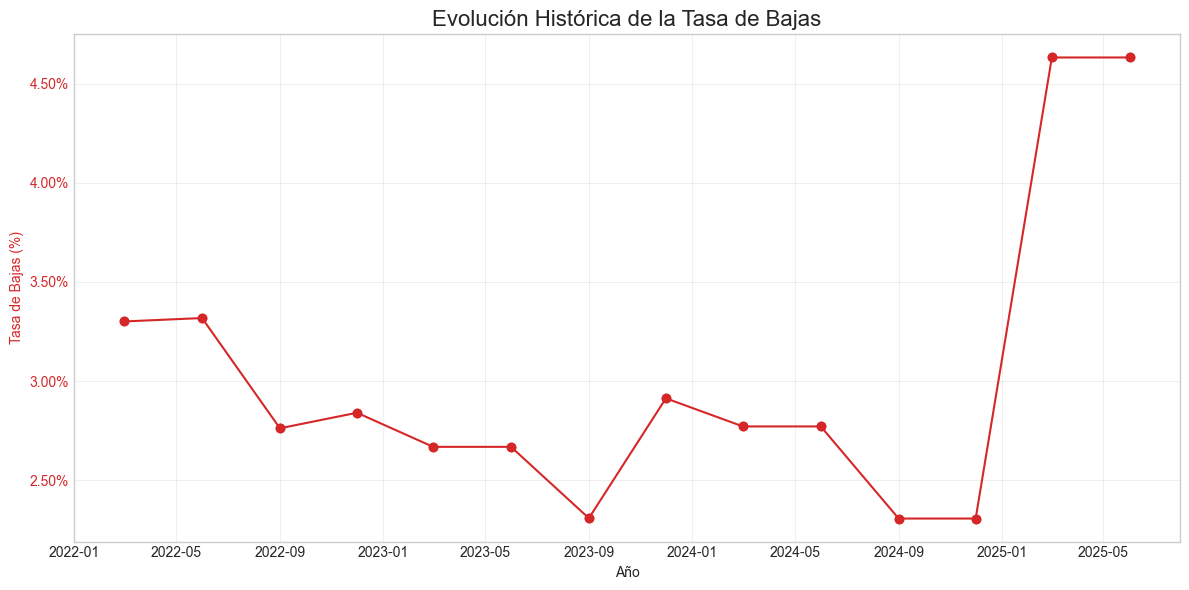

In [15]:
if matricula_df is not None and bajas_df is not None:
    # Merge
    df_dropout = pd.merge(matricula_df, bajas_df, on='date', how='inner', suffixes=('_mat', '_bajas'))
    
    # Cálculo de Tasa
    df_dropout['dropout_rate'] = (df_dropout['bajas'] / df_dropout['m_licenciatura']) * 100

    # Graficar
    fig, ax = plt.subplots(figsize=(12, 6))
    color = 'tab:red'
    ax.set_xlabel('Año')
    ax.set_ylabel('Tasa de Bajas (%)', color=color)
    ax.plot(df_dropout.index, df_dropout['dropout_rate'], color=color, marker='o', label='Tasa de Bajas')
    ax.tick_params(axis='y', labelcolor=color)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    
    plt.title('Evolución Histórica de la Tasa de Bajas', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../reports/figures/longitudinal_dropout_rate.png')
    plt.show()

## 3. Evolución de la Carga Docente

Analizamos la relación entre estudiantes y docentes, comparando las modalidades Presencial/Híbrida vs. Distancia.

**Nota:** Se asume una distribución estimada de la matrícula de **60% Distancia / 40% Presencial** para calcular los ratios específicos, dado que la matrícula total no está desagregada en el histórico.

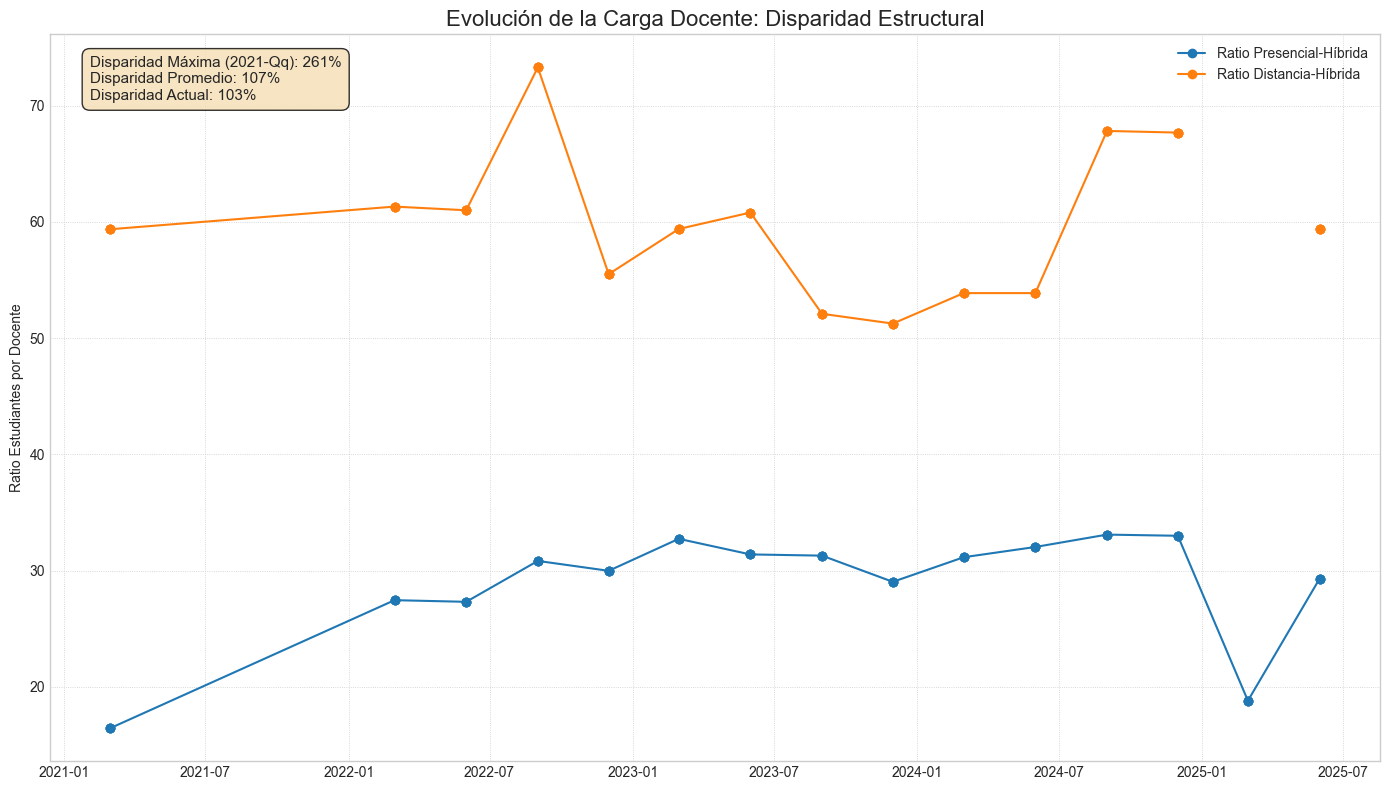

In [16]:
if matricula_df is not None and docentes_df is not None:
    # Merge
    df_workload = pd.merge(matricula_df, docentes_df, on='date', how='inner')
    
    # Estimación de Matrícula por Modalidad (Supuesto 60/40)
    df_workload['Matricula_Distancia'] = df_workload['m_licenciatura'] * 0.6
    df_workload['Matricula_Presencial'] = df_workload['m_licenciatura'] * 0.4
    
    # Cálculo de Ratios (Estudiantes por Docente)
    # d_licenciatura_PH: Docentes Presencial/Híbrido
    # d_licenciatura_D: Docentes Distancia
    df_workload['Ratio_Presencial'] = df_workload['Matricula_Presencial'].divide(df_workload['d_licenciatura_PH']).replace(np.inf, np.nan)
    df_workload['Ratio_Distancia'] = df_workload['Matricula_Distancia'].divide(df_workload['d_licenciatura_D']).replace(np.inf, np.nan)
    
    # Cálculo de KPIs de Disparidad
    df_workload['Disparidad_Porcentual'] = ((df_workload['Ratio_Distancia'] / df_workload['Ratio_Presencial']) - 1) * 100
    valid_disparity = df_workload['Disparidad_Porcentual'].dropna()
    
    if not valid_disparity.empty:
        disparidad_actual = valid_disparity.iloc[-1]
        disparidad_promedio = valid_disparity.mean()
        disparidad_maxima = valid_disparity.max()
        trimestre_pico = valid_disparity.idxmax()
        
        # Graficar
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(df_workload.index, df_workload['Ratio_Presencial'], color='tab:blue', marker='o', label='Ratio Presencial-Híbrida')
        ax.plot(df_workload.index, df_workload['Ratio_Distancia'], color='tab:orange', marker='o', label='Ratio Distancia-Híbrida')
        
        ax.set_title('Evolución de la Carga Docente: Disparidad Estructural', fontsize=16)
        ax.set_ylabel('Ratio Estudiantes por Docente')
        ax.legend(loc='upper right')
        ax.grid(True, linestyle=':', linewidth=0.6)
        
        # Box de Insights
        kpi_text = (
            f"Disparidad Máxima ({trimestre_pico.strftime('%Y-Q%q')}): {disparidad_maxima:.0f}%\n"
            f"Disparidad Promedio: {disparidad_promedio:.0f}%\n"
            f"Disparidad Actual: {disparidad_actual:.0f}%"
        )
        props = dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8)
        ax.text(0.03, 0.97, kpi_text, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        plt.savefig('../reports/figures/longitudinal_workload_disparity.png')
        plt.show()

## 4. Tasa de Conversión a Titulación

Analizamos la eficiencia terminal comparando el acumulado de titulados vs. el acumulado de egresados.

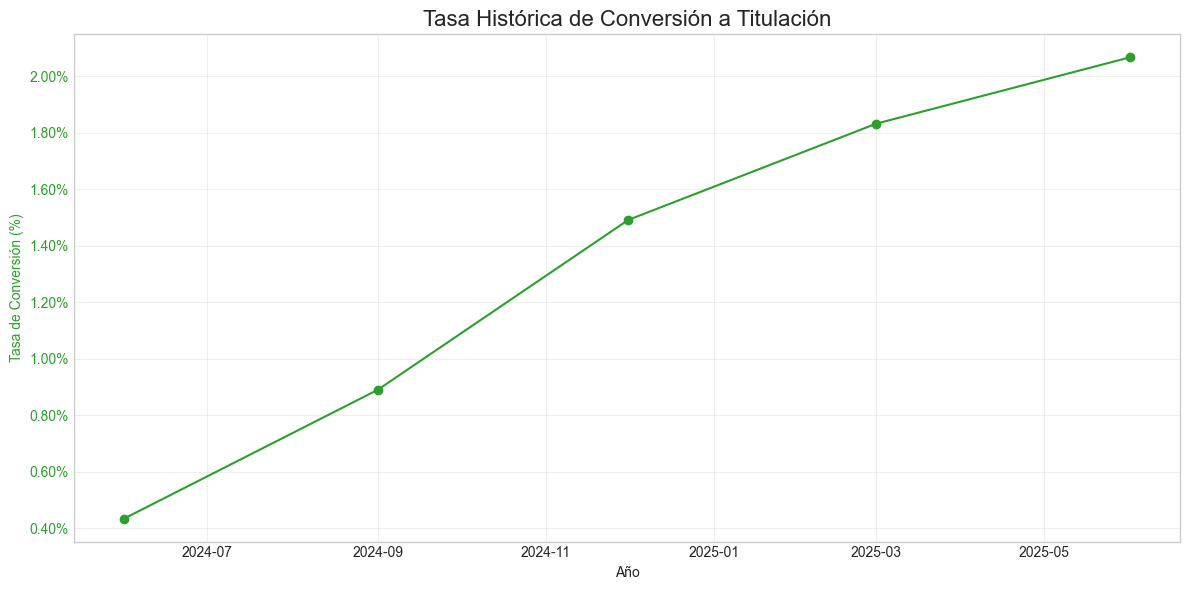

In [17]:
if egresados_df is not None and titulados_df is not None:
    # Calcular acumulados
    egresados_df['egresados_acumulados'] = egresados_df['egresados'].cumsum()
    titulados_df['titulados_acumulados'] = titulados_df['titulados'].cumsum()
    
    # Merge
    df_grad = pd.merge(egresados_df, titulados_df, on='date', how='inner')
    
    # Tasa de Conversión
    df_grad['tasa_conversion'] = (df_grad['titulados_acumulados'] / df_grad['egresados_acumulados']) * 100
    
    # Graficar
    fig, ax = plt.subplots(figsize=(12, 6))
    color = 'tab:green'
    ax.set_xlabel('Año')
    ax.set_ylabel('Tasa de Conversión (%)', color=color)
    ax.plot(df_grad.index, df_grad['tasa_conversion'], color=color, marker='o', label='Conversión a Titulación')
    
    ax.tick_params(axis='y', labelcolor=color)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    
    plt.title('Tasa Histórica de Conversión a Titulación', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../reports/figures/longitudinal_graduation_rate.png')
    plt.show()

## 5. Tasa de Egreso (Eficiencia de Flujo)\n
\n
Esta métrica compara la cantidad de **Egresados** (quienes terminan materias) vs la **Matrícula Total** activa.\n
\n
**¿Qué nos muestra?**\n
*   Es un proxy de la **velocidad de flujo** de la universidad.\n
*   Si una carrera dura 5 años, en un estado estacionario ideal, esperaríamos una tasa anual cercana al 20% (o ~5% trimestral).\n
*   Valores muy bajos indican **embalsamiento** (estudiantes que se demoran mucho en terminar) o alta deserción tardía.

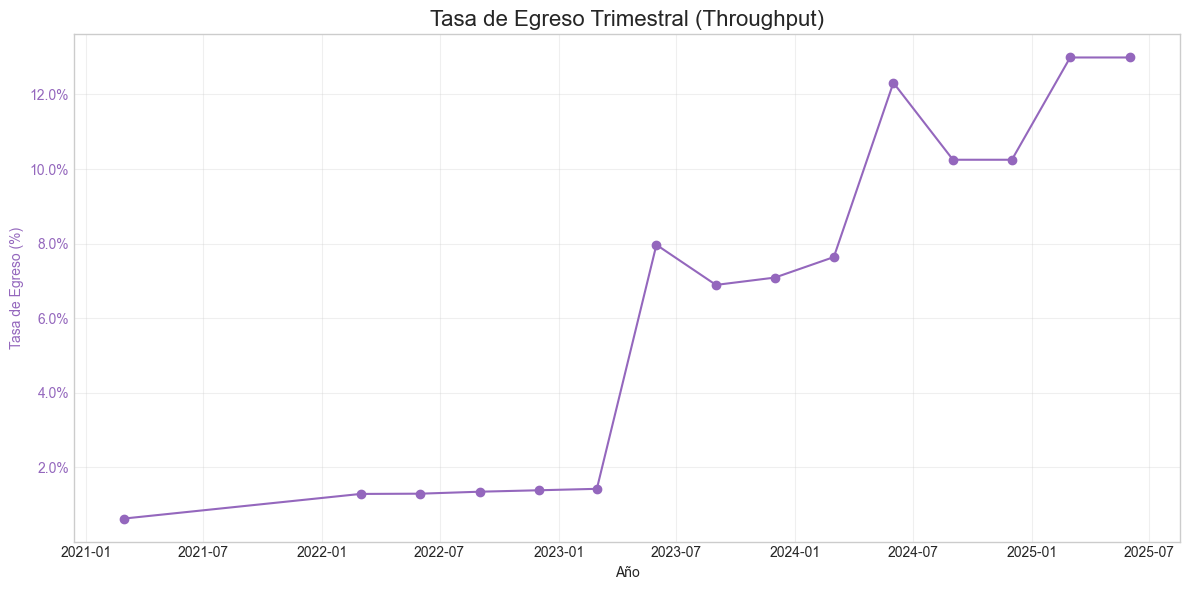

In [18]:
if matricula_df is not None and egresados_df is not None:
    # Merge
    df_flow = pd.merge(matricula_df, egresados_df, on='date', how='inner')
    
    # Tasa de Egreso (Egresados / Matrícula Total)
    df_flow['tasa_egreso'] = (df_flow['egresados'] / df_flow['m_licenciatura']) * 100
    
    # Graficar
    fig, ax = plt.subplots(figsize=(12, 6))
    color = 'tab:purple'
    ax.set_xlabel('Año')
    ax.set_ylabel('Tasa de Egreso (%)', color=color)
    ax.plot(df_flow.index, df_flow['tasa_egreso'], color=color, marker='o', linestyle='-', label='Tasa de Egreso')
    
    ax.tick_params(axis='y', labelcolor=color)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    
    plt.title('Tasa de Egreso Trimestral (Throughput)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../reports/figures/longitudinal_throughput_rate.png')
    plt.show()